## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [1]:
!pip install --upgrade -q xgboost scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 15.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 91.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


### Importação de Bibliotecas

In [2]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_final_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, f1_score,
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna
import shap

### Definição de Constantes Auxiliares

### Obtenção e análise dos dados

In [3]:
RANDOM_STATE = 42

TEST_RATIO = 0.2

NUMERIC_ATTRS = ["idade_paciente", "dias_sintomas_notificacao"]

NUM_CLASSES = 3

In [4]:
df_sinan_processed = pd.read_csv("../input/sinan-processed/dataset-processed.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

In [6]:
X.head()

,idade_paciente,possui_doenca_autoimune,possui_diabetes,possui_doencas_hematologicas,possui_hepatopatias,possui_doenca_renal,possui_hipertensao,possui_doenca_acido_peptica,apresenta_febre,apresenta_cefaleia,...,one_hot_raca_cor_paciente_4,one_hot_raca_cor_paciente_5,one_hot_raca_cor_paciente_9,one_hot_gestante_paciente_1,one_hot_gestante_paciente_2,one_hot_gestante_paciente_3,one_hot_gestante_paciente_4,one_hot_gestante_paciente_5,one_hot_gestante_paciente_6,one_hot_gestante_paciente_9
0,15.0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,24.0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
2,21.0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
3,35.0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,49.0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: severity, dtype: int64

### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação (holdout ou LOOCV).

In [8]:
# X e y originais (~700k linhas)
# X_opt será usado no Optuna (~560k linhas)
# X_final_test vai para o cofre (~140k linhas)

X_opt, X_final_test, y_opt, y_final_test = train_final_test_split(
    X, y, test_size=TEST_RATIO, stratify=y, random_state=RANDOM_STATE
)

## Hyperparameter Tuning com Optuna

### Definição da Função Objetivo

In [11]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import optuna
import cupy as cp
import numpy as np

# SMOTE só roda na CPU
X_cpu = X_opt.values
y_cpu = y_opt.values


def objective(trial):
    param = {
        # --- Configurações fixas (GPU + Multiclasse) ---
        "verbosity": 0,
        "objective": "multi:softprob",
        "num_class": NUM_CLASSES,
        "tree_method": "hist",
        "device": "cuda",
        "eval_metric": "mlogloss",
        "random_state": RANDOM_STATE,
        "early_stopping_rounds":50,

        # --- Espaço de busca ---
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1),
        "reg_alpha": trial.suggest_int("reg_alpha", 1, 50),
        "reg_lambda": trial.suggest_int("reg_lambda", 1, 50),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.5),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = []

    for train_idx, valid_idx in skf.split(X_cpu, y_cpu):

        # --- Split ---
        X_train_fold, y_train_fold = X_cpu[train_idx], y_cpu[train_idx]
        X_valid_fold, y_valid_fold = X_cpu[valid_idx], y_cpu[valid_idx]

        # --- Normalização ---
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_valid_fold = scaler.transform(X_valid_fold)

        # --- SMOTE apenas no treino ---
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # --- Conversão para GPU ---
        X_train_gpu = cp.asarray(X_train_resampled)
        y_train_gpu = cp.asarray(y_train_resampled)
        X_valid_gpu = cp.asarray(X_valid_fold)
        y_valid_gpu = cp.asarray(y_valid_fold)

        # --- Modelo ---
        model = xgb.XGBClassifier(**param)

        model.fit(
            X_train_gpu, y_train_gpu,
            eval_set=[(X_valid_gpu, y_valid_gpu)],
            verbose=False
        )

        # --- Avaliação ---
        preds = model.predict(X_valid_gpu)
        f1 = f1_score(y_valid_fold, cp.asnumpy(preds), average='macro')
        scores.append(f1)

    return np.mean(scores)

In [12]:
# Create and run the optimization process with 100 trials
study = optuna.create_study(study_name="xgboost_study_cuda", direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True, n_jobs=-1)

# Retrieve the best parameter values
best_params = study.best_params
print(f"\nBest parameters: {best_params}")

[I 2025-11-30 20:09:45,338] A new study created in memory with name: xgboost_study_cuda


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-11-30 20:30:46,885] Trial 0 finished with value: 0.5396793613053188 and parameters: {'n_estimators': 3300, 'max_depth': 9, 'learning_rate': 0.16, 'subsample': 1.0, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 27, 'reg_lambda': 43, 'min_child_weight': 4, 'gamma': 1.5}. Best is trial 0 with value: 0.5396793613053188.
[I 2025-11-30 20:32:25,666] Trial 1 finished with value: 0.5336078262744007 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.13, 'subsample': 0.6, 'colsample_bytree': 0.2, 'reg_alpha': 5, 'reg_lambda': 12, 'min_child_weight': 9, 'gamma': 1.0}. Best is trial 0 with value: 0.5396793613053188.
[I 2025-11-30 20:34:52,960] Trial 3 finished with value: 0.5377314542378752 and parameters: {'n_estimators': 4300, 'max_depth': 7, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 3, 'reg_lambda': 49, 'min_child_weight': 5, 'gamma': 2.0}. Best is trial 0 with value: 0.5396793613053188.
[I 2025-11-30 20:42:18,328] Trial

### Visualizações do Optuna

In [17]:
import optuna.visualization as vis

display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

## Avaliação Final

In [21]:
from sklearn.metrics import classification_report
import cupy as cp

# 1. Recuperar os melhores parâmetros do estudo
final_params = study.best_params
final_params['tree_method'] = 'hist'
final_params['device'] = 'cuda'
final_params['objective'] = 'multi:softprob'
final_params['num_class'] = NUM_CLASSES
final_params['eval_metric'] = 'mlogloss'
final_params['random_state'] = RANDOM_STATE

# Nota: early_stopping_rounds geralmente não se usa no treino final 
# a menos que você separe uma validação extra. Vamos confiar nos params do Optuna.

# -----------------------------------------------------------
# 2. PREPARAÇÃO DOS DADOS (O Passo que faltava)
# -----------------------------------------------------------
print("Preparando dados para o treino final...")

# A. Normalizar os dados de TREINO (X_opt)
scaler_final = StandardScaler()
X_opt_scaled = scaler_final.fit_transform(X_opt) # X_opt são os 560k dados

# B. Aplicar SMOTE nos dados de TREINO
smote_final = SMOTE(random_state=42)
X_opt_resampled, y_opt_resampled = smote_final.fit_resample(X_opt_scaled, y_opt)

# C. Mandar para GPU
X_train_final_gpu = cp.asarray(X_opt_resampled)
y_train_final_gpu = cp.asarray(y_opt_resampled)

# -----------------------------------------------------------
# 3. TREINAR O MODELO (O .fit que faltava)
# -----------------------------------------------------------
print("Treinando o modelo final...")
model_final = xgb.XGBClassifier(**final_params)
model_final.fit(X_train_final_gpu, y_train_final_gpu)

# -----------------------------------------------------------
# 4. AVALIAR NO TESTE (O Cofre)
# -----------------------------------------------------------
print("Avaliando no conjunto de teste final...")

# D. Preparar o Teste (X_final_test)
# IMPORTANTE: 
# 1. Usar o MESMO scaler treinado no passo A.
# 2. NÃO usar SMOTE aqui.
# 3. Mandar para GPU.
X_test_scaled = scaler_final.transform(X_final_test)
X_test_gpu = cp.asarray(X_test_scaled)

# E. Prever
y_pred_final_test_gpu = model_final.predict(X_test_gpu)
y_pred_final_test = cp.asnumpy(y_pred_final_test_gpu) # Volta para CPU para o relatório

# F. Relatório
print("Relatório de Classificação no Conjunto de Teste:")
print(classification_report(y_final_test, y_pred_final_test, target_names=target_names, zero_division=0))

Preparando dados para o treino final...
Treinando o modelo final...
Avaliando no conjunto de teste final...
Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

    low_risk       0.76      0.82      0.79     84170
       alarm       0.64      0.57      0.61     53509
      severe       0.25      0.19      0.22      5705

    accuracy                           0.71    143384
   macro avg       0.55      0.53      0.54    143384
weighted avg       0.70      0.71      0.70    143384



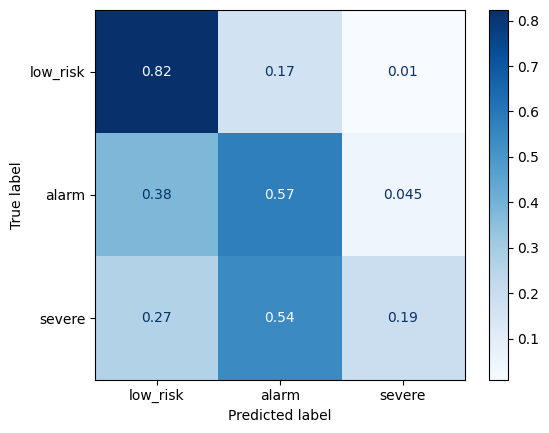

In [25]:
ConfusionMatrixDisplay.from_predictions(y_final_test, y_pred_final_test, display_labels=target_names, cmap=plt.cm.Blues, normalize='true')

plt.savefig("optimized_clf_confusion_matrix.pdf")
plt.show()

In [24]:
def plot_metrics_by_class(y_true, y_pred, target_names, figsize=(10, 6)):
    # Obter report como dicionário
    report_dict = classification_report(y_true, y_pred, target_names=target_names, 
                                       zero_division=0, output_dict=True)
    
    # Criar figura
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(target_names))
    width = 0.25
    
    # Preparar dados
    precision_values = [report_dict[cls]['precision'] for cls in target_names]
    recall_values = [report_dict[cls]['recall'] for cls in target_names]
    f1_values = [report_dict[cls]['f1-score'] for cls in target_names]
    
    # Criar barras
    bars1 = ax.bar(x - width, precision_values, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recall_values, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1_values, width, label='F1-Score', alpha=0.8)
    
    # Adicionar valores no topo das barras
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)
    
    # Configurar gráfico
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.set_title('Classification Metrics by Class', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(target_names)
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax, report_dict

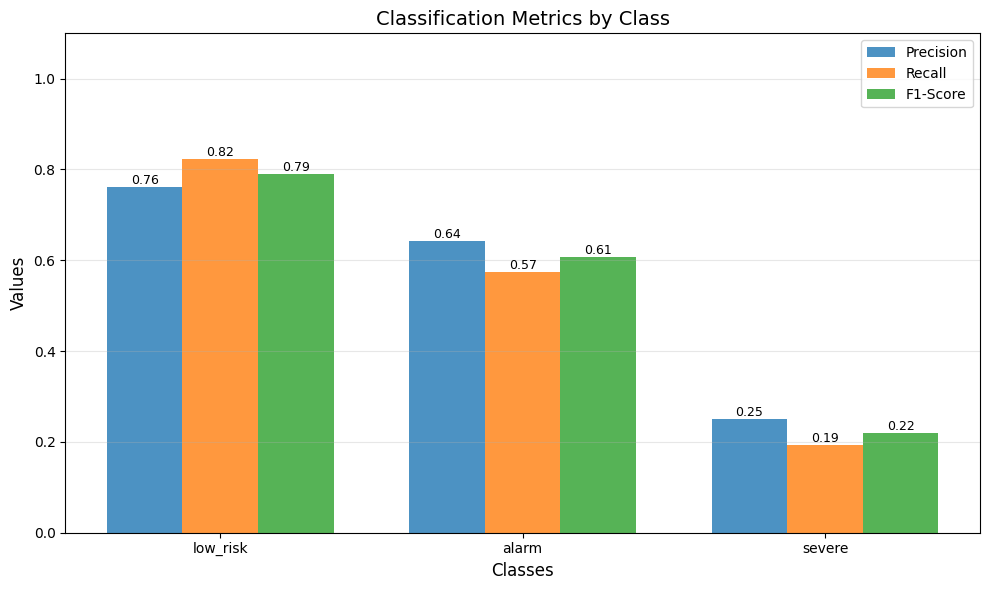

In [26]:
fig, ax, report_dict = plot_metrics_by_class(y_final_test, y_pred_final_test, target_names=target_names)

plt.savefig("optimized_clf_metrics_by_class.pdf")
plt.show()

## Interpretação dos Resultados com SHAP

In [28]:
# Using SHAP to explain the optimized model
explainer = shap.Explainer(best_clf, X_train_resampled)
shap_values = explainer(X_final_test)

shap.summary_plot(shap_values, X_final_test, feature_names=feature_names, show=False)
plt.savefig("optimized_clf_shap_summary_plot.pdf")
plt.show()

NameError: name 'best_clf' is not defined